# Tarea 2: Programación No Lineal
## Autor: Leonard David Vivas Dallos

### Instrucción: 
Esta actividad se realizará en forma individual. Las actividades a realizar son las siguientes: 

1. Elija un ejemplo donde se requiera encontrar los parámetros a un modelo matemático y se disponga de datos experimentales. Se solicita que el modelo sea de algo aplicado a un problema real. 
2. Implemente el método de región de confianza y de Gauss-Newton.
3. Utilice ambos algoritmos para resolver el problema seleccionado. ¿Qué diferencias detectó?
4. Realice un informe escrito donde describa el ejemplo seleccionado con las referencias correspondientes. Adicionalmente, muestre la solución del problema usando los dos métodos y haga una discusión de los resultados obtenidos.  

Se deben subir al Moodle los siguientes archivos: 
- Informe escrito 
- Códigos usados en las implementaciones

### 1. Selección del problema
Para esta tarea se seleccionó el problema de ajuste de curvas a un conjunto de datos experimentales. En particular, intentaremos ajustar un modelo exponencial a un conjunto de datos poblacionales alojados en el archivo 'PoblaciónEspaña.csv' y tomados de la página del Instituto Nacional de Estadística, con enlace "https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736177095&menu=ultiDatos&idp=1254735572981". El modelo exponencial se define como:

$$C(t) = C_0 e^{kt}$$

Donde $C(t)$ es la población en el tiempo $t$, $C_0$ es la población inicial y $k$ es la tasa de crecimiento. El objetivo es encontrar los valores de $C_0$ y $k$ que mejor se ajusten a los datos experimentales.

Para esto, se planteará el problema como un problema de optimización no lineal, donde la función objetivo a minimizar es:

$$\min_{C_0, k} \sum_{i=1}^{n} (C_i - C_0 e^{kt_i})^2$$

Donde $C_i$ es la población en el tiempo $t_i$ y $n$ es el número de datos experimentales.

El conjunto de datos corresponde a la población residente en España en los años entre los años 1971 - 2024, delimitando periodos de tiempo trimestrales entre los datos (sin embargo, no se cuenta con la totalidad de los 4 trimestres en algunos años). A continuación se muestra la carga de los datos y la visualización de los mismos.

In [1]:
# Definición de los datos experimentales
import pandas as pd

# Lectura de los datos omitiendo las primeras 7 filas
data = pd.read_csv('PoblaciónEspaña.csv', skiprows=7)

# Solo nos interesan las columnas 'PERIODO' y 'VALOR'
data = data[['PERIODO','VALOR']]

# Visualización de los datos
data.head()

# NOTA: Si se desean ver todos los datos, se puede ingresar como parámetro de la función 'head' el número de datos a visualizar
# Ejemplo: data.head(10)

,PERIODO,VALOR
0,2024T1,48.592.909
1,2023T4,48.507.039
2,2023T3,48.373.336
3,2023T2,48.233.001
4,2023T1,48.085.361


Notemos que el periodo de tiempo se encuentra en una escala trimestral, en un formato "año + T + trimestre". Ahora bien, para poder manejar este tipo de escalas en el tiempo, se procederá a convertir estos valores a una escala de años, en donde al ser un total de 4 trimestres por año, dependiendo del valor del trimestre, se sumará un valor de 0.25, 0.5, 0.75 o 1 al año correspondiente. Para lograr este fin, se procederá a añadir una columna adicional al índice del DataFrame que contenga el valor de los años en una escala anual.

In [2]:
# Crear una nueva columna con el valor del año en una escala anual
data[['AÑO', 'TRIMESTRE']] = data['PERIODO'].str.split('T', expand=True)

# Convertir 'año' y 'periodo' a enteros
data['AÑO'] = data['AÑO'].astype(int)
data['TRIMESTRE'] = data['TRIMESTRE'].astype(int)

# Crear una nueva columna que sea la suma de 'año' y 'periodo'
data['TIEMPO'] = data['AÑO'] + data['TRIMESTRE']/4

# Eliminar las columnas 'AÑO' y 'TRIMESTRE'
data = data.drop(columns=['AÑO', 'TRIMESTRE', 'PERIODO'])

# Adicionar la columna 'TIEMPO' al índice
data = data.set_index('TIEMPO')

# Renombrar la columna 'VALOR' a 'POBLACIÓN'
data = data.rename(columns={'VALOR': 'POBLACIÓN'})

data.head()

,POBLACIÓN
TIEMPO,
2024.25,48.592.909
2024.00,48.507.039
2023.75,48.373.336
2023.50,48.233.001
2023.25,48.085.361


Ahora bien, por temas de manejo en el lenguaje de programación Python, notemos que los números que hacen referencia a la población contienen puntos de separación de miles, lo cual puede ser un problema a la hora de realizar operaciones matemáticas con estos datos. Por lo tanto, se procederá a quitar estos puntos y a convertir los datos a un tipo de dato numérico, con el fin de poder realizar operaciones matemáticas con los mismos.

In [3]:
# Primero debo quitar los puntos de los datos
data['POBLACIÓN'] = [x.replace('.','') for x in data['POBLACIÓN']]
# Convertir los valores a tipo float
data['POBLACIÓN'] = data['POBLACIÓN'].astype(int)

data.head()

,POBLACIÓN
TIEMPO,
2024.25,48592909
2024.00,48507039
2023.75,48373336
2023.50,48233001
2023.25,48085361


Ahora que se ha realizado la conversión de los datos a una escala anual, se procederá a visualizar los datos experimentales en una gráfica numérica, para darnos una idea de cómo se comporta la población en función del tiempo y de la forma en que debería ajustarse el modelo exponencial a los datos experimentales.

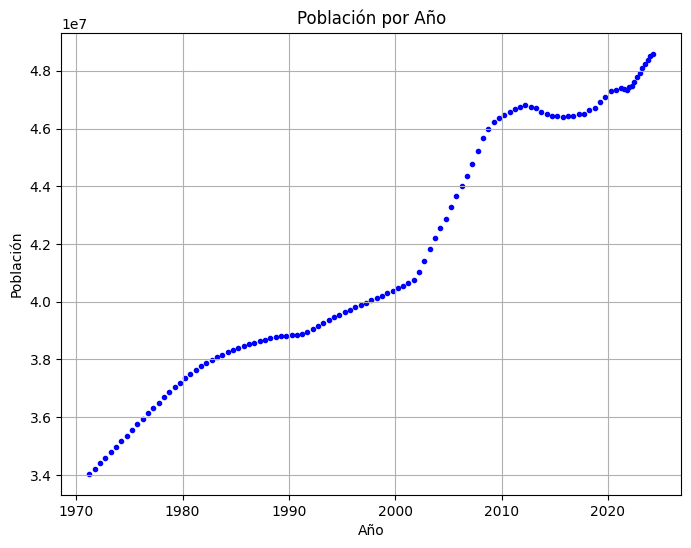

In [4]:
# Visualización de los datos experimentales en una gráfica numerica
import matplotlib.pyplot as plt

import numpy as np

# Graficar los datos
plt.figure(figsize=(8, 6))  # Definir el tamaño de la figura
plt.scatter(data.index, data['POBLACIÓN'], color='blue', marker='.')  # Scatter plot
plt.title('Población por Año')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y



plt.grid(True)  # Mostrar una cuadrícula en el gráfico
plt.show()  # Mostrar el gráfico

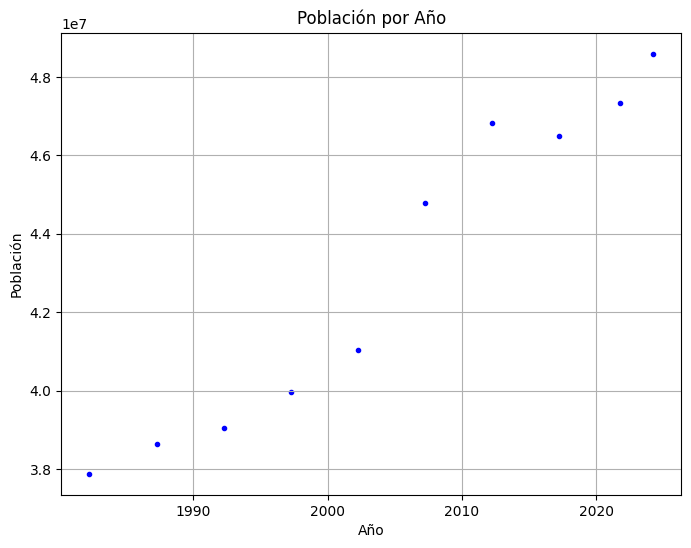

,POBLACIÓN
TIEMPO,
2024.25,48592909
2021.75,47346836
2017.25,46497393
2012.25,46818216
2007.25,44784659
2002.25,41035271
1997.25,39971329
1992.25,39051336
1987.25,38638052


In [5]:
# Muestro algunos de los datos (aproximadamente 10) en una gráfica para una mejor visualización de la situación
# Graficar los datos
plt.figure(figsize=(8, 6))  # Definir el tamaño de la figura

# Seleccionar manualmente 10 datos
data_10 = data.iloc[[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]]

plt.scatter(data_10.index, data_10['POBLACIÓN'], color='blue', marker='.')  # Scatter plot

plt.title('Población por Año')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y


plt.grid(True)  # Mostrar una cuadrícula en el gráfico
plt.show()  # Mostrar el gráfico

# Imprimir los datos seleccionados
data_10

Como prueba adicional, haremos una copia de los datos en otra variable con el fin de realizarle unas pequeñas modificaciones, estas consisten en hacer una traslación del tiempo, de manera que, haremos que nuestro tiempo inicial (t=0) s











































































































































































































































































































































































































































































ea el año 1971, esto con el fin de poder ajustar el modelo exponencial a los datos experimentales de una mejor manera. A continuación se procederá a realizar esta traslación y a visualizar los datos experimentales en una gráfica numérica.

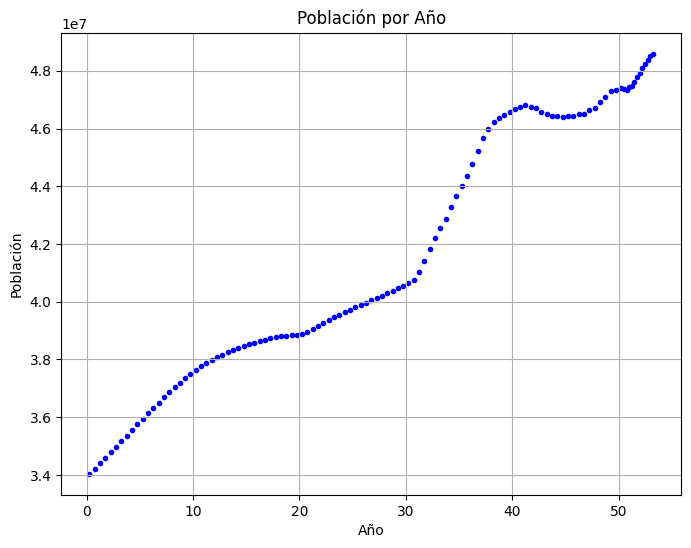

,POBLACIÓN
TIEMPO,
53.25,48592909
53.00,48507039
52.75,48373336
52.50,48233001
52.25,48085361


In [6]:
# Crear una copia de los datos
data_traslacion = data.copy()

# Trasladar el tiempo para que el tiempo inicial sea el año 1971
data_traslacion.index = data_traslacion.index - 1971

# Visualización de los datos experimentales en una gráfica numerica
plt.figure(figsize=(8, 6))  # Definir el tamaño de la figura
plt.scatter(data_traslacion.index, data_traslacion['POBLACIÓN'], color='blue', marker='.')  # Scatter plot
plt.title('Población por Año')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y

plt.grid(True)  # Mostrar una cuadrícula en el gráfico

plt.show()  # Mostrar el gráfico

# Imprimir los datos
data_traslacion.head()

Con unos datos menos haremos un análisis de la situación, con el fin de darnos una idea de como se comporta la población en función del tiempo y de la forma en que debería ajustarse el modelo exponencial a los datos experimentales, esto con el fin de poder situarnos en un punto inicial el cual optimizar. Así pues, tratemos con algunos valores con el fin de ver como se visualiza en el modelo.

### 2. Implementación de los métodos
Primero se procederá a definir la función objetivo a minimizar, la cual corresponde a la suma de los errores cuadráticos entre los datos experimentales y el modelo exponencial. Posteriormente, se implementarán los métodos de región de confianza y Gauss-Newton para encontrar los valores de $C_0$ y $k$ que mejor se ajusten a los datos experimentales.


In [7]:
# Definición de la función objetivo
def objective_function(params, t, C):
    C0, k = params
    return np.sum((C - C0 * np.exp(k * t)) ** 2) / 2

#### Método de Región de Confianza

In [28]:
from autograd import grad, hessian, jacobian
import autograd.numpy as np

# Definición de la función m_k
def m_k(funcion_objetivo, params, t, C, p):
    return funcion_objetivo(params, t, C) + grad(funcion_objetivo)(params, t, C).dot(p) + 0.5 * p.dot((hessian(funcion_objetivo)(params, t, C) @ p))

# Implementación del algoritmo de dirección usando el método de Dogleg
def algoritmo_dogleg(grad_f, hess_f, r_k):
    p_u = - (grad_f.dot(grad_f) / (grad_f.dot(hess_f * grad_f))) * grad_f
    p_n = - np.linalg.inv(hess_f) @ grad_f
    
    if np.linalg.norm(p_n) <= r_k:
        return p_n
    
    if np.linalg.norm(p_u) >= r_k:
        return - r_k * p_u / np.linalg.norm(p_u)
    else:
        # Resolver la ecuación cuadrática a(τ − 1)2 + b(τ − 1) + c = 0
        a = p_n.dot(p_n) - 2 * p_n.dot(p_u) + p_u.dot(p_u)
        b = 2 * p_n.dot(p_u) - 2 * p_u.dot(p_u)
        c = p_u.dot(p_u) - r_k**2
        tau = (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)
        tau = tau + 1
        return p_u + tau * (p_n - p_u)

# Implementación del método de región de confianza
def region_confianza(funcion_objetivo, initial_params, t, C, delta = 0.75, eta = 0.2, max_iter = 6000, tol = 1e-6):
    params = initial_params
    radius = 0.5
    iteration = 0
    while funcion_objetivo(params, t, C) > tol and iteration < max_iter:
        
        # Calculamos el gradiente y la matriz Hessiana
        grad_f = grad(funcion_objetivo)(params, t, C)
        hess_f = hessian(funcion_objetivo)(params, t, C)
        
        # Obtener la dirección de descenso p_k
        p_k = algoritmo_dogleg(grad_f, hess_f, radius)

        # Evaluar rho_k
        rho_k = (funcion_objetivo(params, t, C) - funcion_objetivo((params + p_k), t, C)) / (m_k(funcion_objetivo, params, t, C, np.array([0,0])) - m_k(funcion_objetivo, params, t, C, p_k))
        
        # Actualizar el radio de confianza
        if rho_k < 0.25:
            radius = np.linalg.norm(p_k) / 4
        else:
            if rho_k > 0.75 and np.linalg.norm(p_k) == radius:
                radius = min(2 * radius, delta)
        
        # Actualizar los parametros
        if rho_k > eta:
            params += p_k
            
        iteration += 1
        
    return params, iteration

#### Método de Gauss-Newton
Para el método de Gauss-Newton, se hace uso de los algoritmos desarrollados en la tarea 1, aquellos que corresponden a la búsqueda del tamaño de paso de manera que se cumplan las condiciones de Armijo y Wolfe. A continuación se presentan los algoritmos desarrollados en la tarea 1.


In [9]:
# Definimos la condición de Armijo
def condicion_armijo(f, x, t, C, p, alpha, c1):
    return f(x + alpha * p, t, C) <= f(x, t, C) + c1 * alpha * grad(f)(x, t, C).dot(p)


# Definimos la condición de Wolfe
def condicion_wolfe(f, x, t, C, p, alpha, c2):
    return grad(f)(x + alpha * p, t, C).dot(p) >= c2 * grad(f)(x, t, C).dot(p)


# Algoritmo de búsqueda de paso
def busqueda_paso(f, x, t, C, p, alpha, c1, c2, rho):
    # Verificamos que los valores de los parámetros sean válidos
    if c1 <= 0 or c1 >= 1:
        print('El valor de c1 no es válido')
        return
    if c2 <= c1 or c2 >= 1:
        print('El valor de c2 no es válido')
        return
    if rho <= 0 or rho >= 1:
        print('El valor de rho no es válido')
        return
    # Buscamos el tamaño de paso
    while not (condicion_wolfe(f, x, t, C, p, alpha, c2) and condicion_armijo(f, x, t, C, p, alpha, c1)):
        alpha = rho * alpha
    return alpha

In [10]:
# Implementación del método de Gauss-Newton
def gauss_newton(funcion_objetivo, x0, t, C, tol=1e-6, max_iter=100):
    x = x0
    iteration = 0

    # Definimos la función r_k
    def r_k(x, t, C):
        return (C - x[0] * np.exp(x[1] * t))**2

    while funcion_objetivo(x, t, C) > tol and iteration < max_iter:
        # Calcular el Jacobiano
        jac_f = jacobian(r_k)(x, t, C)
        
        t1 = np.linalg.inv(np.dot(jac_f.T, jac_f))
        t2 = np.dot(t1, jac_f.T)
        t3 = np.dot(t2, r_k(x, t, C))
        p = t3
        
        # Buscar el tamaño de paso
        alpha = 1
        c1 = 1e-4
        c2 = 0.9
        rho = 0.5
        alpha = busqueda_paso(funcion_objetivo, x, t, C, p, alpha, c1, c2, rho)

        # Actualizar x
        x -= alpha * p

        iteration += 1

    return x   

### 3. Resolución del problema
A continuación se procederá a resolver el problema de ajuste de curvas a los datos experimentales utilizando los métodos de región de confianza y Gauss-Newton implementados anteriormente. Se realizarán dos comparaciones, la primera con el fin de verificar que los métodos desarrollados sean correctos y la segunda para comparar los resultados obtenidos por ambos métodos. Para la primera verificación haremos una comparación con el método de optimización de la librería Scipy, escogiendo los métodos de acuerdo con la documentación brindada por la librería. Nuestra segunda verificación (realizada en el paso 4) será una comparación de los resultados obtenidos por los dos métodos implementados manualmente, con el fin de analizar cual es más conveniente para el problema en cuestión y que diferencias existen entre ellos.

Además de esto, tomaremos como aproximación inicial un arreglo de dos elementos, donde el primer elemento corresponderá a la población inicial y el segundo elemento corresponderá a la tasa de crecimiento. Estos valores iniciales fueron tomados a partir de la relación entre los datos experimentales y la relación esperada entre los mismos, usando el significado conceptual de la tasa de crecimiento. A continuación se procederá a realizar la resolución del problema.

#### Método de Región de Confianza

In [32]:
# Método de región de confianza

# Definir los datos experimentales
t = data.index.values
C = data['POBLACIÓN'].values

# Conversión de los datos a tipo float

t = t.astype(float)
# Convertir los valores a tipo float
C = np.array(C, dtype=float)

# Definir los valores iniciales de C0 y k, estos fueron tomados a partir de lo esperado y la relación entre los datos experimentales
k_inicial = np.log(C[0] / C[-1]) / (t[0] - t[-1])
x0 = np.array([C[-1], k_inicial])

# Resolver el problema utilizando el método de región de confianza
params_rc, itera = region_confianza(objective_function, x0, t, C)
#params_rc = trust_region(x0, objective_function, t, C)
print(itera)

C0_optimo, k_optimo = params_rc

# Mostrar los resultados
print('Parámetros encontrados por región de confianza:')
print('Población inicial estimada (C0):', C0_optimo)
print('Tasa de crecimiento estimada (k):', k_optimo)

# Impresión de espacio
print("")

# Método de optimización de Scipy

from scipy.optimize import minimize

k_inicial = np.log(C[0] / C[-1]) / (t[0] - t[-1])
x0 = np.array([C[-1], k_inicial])

resultado = minimize(objective_function, x0, (t, C), method="dogleg", jac=jacobian(objective_function), hess=hessian(objective_function))

# Resultados
C0_optimo1, k_optimo1 = resultado.x
print("Parámetros encontrados por Scipy:")
print("Población inicial estimada (C0):", C0_optimo1)
print("Tasa de crecimiento estimada (k):", k_optimo1)

6000
Parámetros encontrados por región de confianza:
Población inicial estimada (C0): 34045141.75
Tasa de crecimiento estimada (k): 0.006715583950932809

Parámetros encontrados por Scipy:
Población inicial estimada (C0): 34040642.0
Tasa de crecimiento estimada (k): 0.006715517947539581


In [14]:
# Método de región de confianza con traslación del tiempo

# Definir los datos experimentales
t = data_traslacion.index.values
C = data_traslacion['POBLACIÓN'].values

# Conversión de los datos a tipo float

t = t.astype(float)
# Convertir los valores a tipo float
C = np.array(C, dtype=float)

# Definir los valores iniciales de C0 y k, estos fueron tomados a partir de lo esperado y la relación entre los datos experimentales
k_inicial = np.log(C[0] / C[-1]) / (t[0] - t[-1])
x0 = np.array([C[-1], k_inicial])

# Resolver el problema utilizando el método de región de confianza
params_rc, itera = region_confianza(objective_function, x0, t, C)
#params_rc = trust_region(x0, objective_function, t, C)
print(itera)

C0_optimo, k_optimo = params_rc

# Mostrar los resultados
print('Parámetros encontrados por región de confianza:')
print('Población inicial estimada (C0):', C0_optimo)
print('Tasa de crecimiento estimada (k):', k_optimo)

# Impresión de espacio
print("")

# Método de optimización de Scipy

from scipy.optimize import minimize

k_inicial = np.log(C[0] / C[-1]) / (t[0] - t[-1])
x0 = np.array([C[-1], k_inicial])

resultado = minimize(objective_function, x0, (t, C), method="dogleg", jac=jacobian(objective_function), hess=hessian(objective_function))

# Resultados
C0_optimo1, k_optimo1 = resultado.x
print("Parámetros encontrados por Scipy:")
print("Población inicial estimada (C0):", C0_optimo1)
print("Tasa de crecimiento estimada (k):", k_optimo1)



1000
Parámetros encontrados por región de confianza:
Población inicial estimada (C0): 34040541.99999851
Tasa de crecimiento estimada (k): 0.006715443353231313
Parámetros encontrados por Scipy:
Población inicial estimada (C0): 34431664.999999985
Tasa de crecimiento estimada (k): 0.006581522860060394


#### Método de Gauss-Newton

In [14]:
# Método de Gauss-Newton

# Definir los datos experimentales
t = data.index.values
C = data['POBLACIÓN'].values

# Conversión de los datos a tipo float

t = t.astype(float)
# Convertir los valores a tipo float
C = np.array(C, dtype=float)

# Definir los valores iniciales de C0 y k, estos fueron tomados a partir de lo esperado y la relación entre los datos experimentales
k_inicial = np.log(C[1] / C[0]) / (t[1] - t[0])
x0 = np.array([C[0], k_inicial])

# Resolver el problema utilizando el método de Gauss-Newton
params_gn = gauss_newton(objective_function, x0, t, C)

C0_optimo2, k_optimo2 = params_gn

# Mostrar los resultados
print('Parámetros encontrados por el método de Gauss-Newton:')
print('Población inicial estimada (C0):', C0_optimo2)
print('Tasa de crecimiento estimada (k):', k_optimo2)

# Impresión de espacio
print("")

# Método de optimización de Scipy

from scipy.optimize import minimize

k_inicial = np.log(C[1] / C[0]) / (t[1] - t[0])
x0 = np.array([C[0], k_inicial])

resultado2 = minimize(objective_function, x0, (t, C), method="trust-ncg", jac=jacobian(objective_function), hess=hessian(objective_function))

# Resultados
C0_optimo3, k_optimo3 = resultado2.x
print("Parámetros encontrados por Scipy:")
print("Población inicial estimada (C0):", C0_optimo3)
print("Tasa de crecimiento estimada (k):", k_optimo3)

Parámetros encontrados por el método de Gauss-Newton:
Población inicial estimada (C0): 48592909.0
Tasa de crecimiento estimada (k): 0.0070747739131990315

Parámetros encontrados por Scipy:
Población inicial estimada (C0): 48592906.0
Tasa de crecimiento estimada (k): -7.623675705071376e-05


Como pudimos evidenciar, los resultados obtenidos por los métodos manualmente implementados y por los métodos que ofrece la librería Scipy son muy similares, pues difieren en valores minúsculos y poco representativos para el problema, por lo que esto nos sugiere que los métodos implementados son correctos y podemos proceder a analizar los resultados de estos. A continuación se procederá a comparar los resultados obtenidos por ambos métodos.

### 4. Discusión de los resultados obtenidos
En este apartado se procederá a comparar los resultados obtenidos por los métodos de región de confianza y Gauss-Newton. Para esto, se compararán los valores de $C_0$ y $k$ obtenidos por ambos métodos y se realizará una comparación gráfica entre los resultados de ambos modelos. Además de esto, se realizarán ciertas anotaciones con respecto al tiempo de ejecución observado en ambos métodos.

Primero, recordemos cuales fueron los resultados obtenidos por los métodos de región de confianza y Gauss-Newton implementados.

In [15]:
print('Parámetros encontrados por región de confianza:')
print('Población inicial estimada (C0):', C0_optimo)
print('Tasa de crecimiento estimada (k):', k_optimo)

print("")

print('Parámetros encontrados por el método de Gauss-Newton:')
print('Población inicial estimada (C0):', C0_optimo2)
print('Tasa de crecimiento estimada (k):', k_optimo2)

Parámetros encontrados por región de confianza:
Población inicial estimada (C0): 34040742.00000149
Tasa de crecimiento estimada (k): 0.006715519414457933

Parámetros encontrados por el método de Gauss-Newton:
Población inicial estimada (C0): 48592909.0
Tasa de crecimiento estimada (k): 0.0070747739131990315


A primera vista, los valores de $C_0$ y $k$ obtenidos por ambos métodos son muy similares, lo cual sugiere que ambos métodos son efectivos para resolver el problema de ajuste de curvas a los datos experimentales. A continuación se procederá a realizar una comparación gráfica entre los resultados obtenidos por ambos métodos.

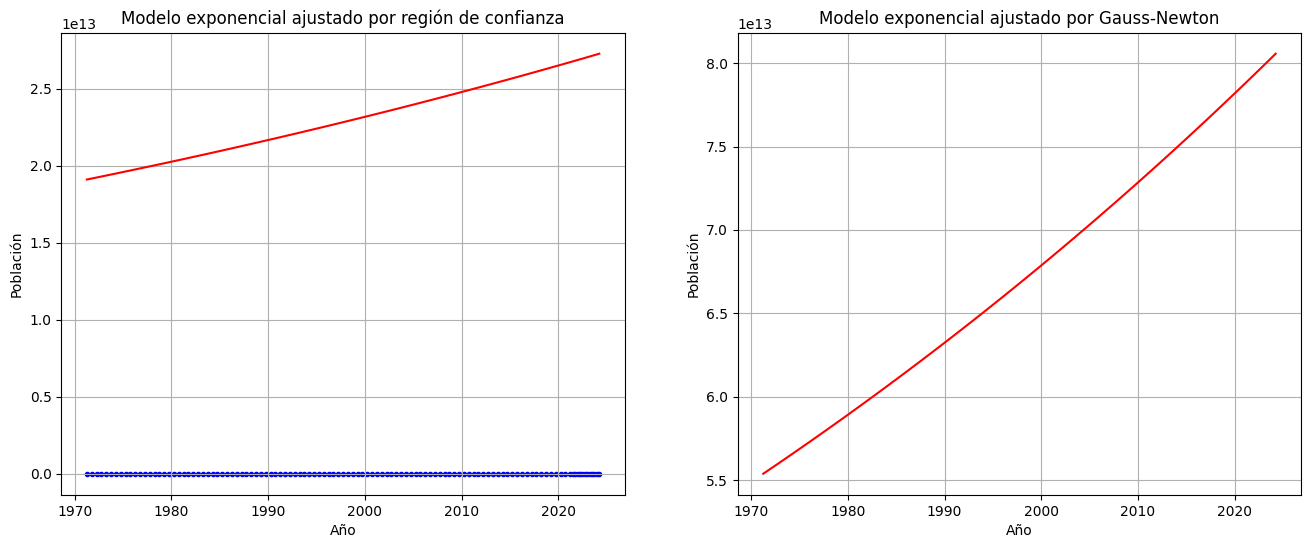

In [24]:
# Visualización de la función obtenida según el método de región de confianza y Gauss-Newton en una figura que tiene al lado izquierdo la función obtenida por región de confianza y al lado derecho la función obtenida por Gauss-Newton
plt.figure(figsize=(16, 6))  # Definir el tamaño de la figura

# Gráfico de la función obtenida por región de confianza
plt.subplot(1, 2, 1)  # Subgráfico 1
plt.plot(data.index, C0_optimo * np.exp(k_optimo * t), color='red')  # Modelo exponencial ajustado
plt.scatter(data.index, data['POBLACIÓN'], color='blue', marker='.')  # Scatter plot
plt.title('Modelo exponencial ajustado por región de confianza')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y

plt.grid(True)  # Mostrar una cuadrícula en el gráfico

# Gráfico de la función obtenida por Gauss-Newton
plt.subplot(1, 2, 2)  # Subgráfico 2
plt.plot(data.index, C0_optimo2 * np.exp(k_optimo2 * t), color='red')  # Modelo exponencial ajustado
plt.title('Modelo exponencial ajustado por Gauss-Newton')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y

plt.grid(True)  # Mostrar una cuadrícula en el gráfico

plt.show()  # Mostrar el gráfico

Ahora realizaremos la impresión de la gráfica de la optimización realizada con los cambios en el tiempo, con el fin de ver como se comporta la población en función del tiempo y de la forma en que debería ajustarse el modelo exponencial a los datos experimentales.

ValueError: x and y must have same first dimension, but have shapes (113,) and (10,)

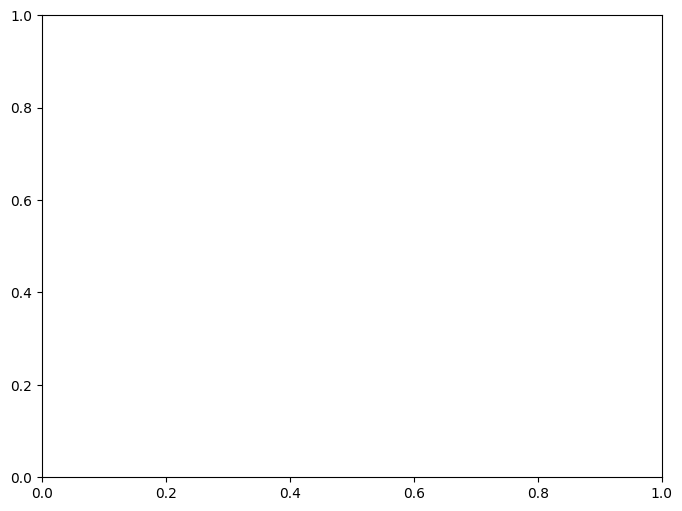

In [19]:
# Visualización de la función obtenida con los datos trasladados usando la función obtenida por el metodo de region de confianza
plt.figure(figsize=(8, 6))  # Definir el tamaño de la figura

# Gráfico de la función obtenida por región de confianza
plt.plot(data_traslacion.index, C0_optimo * np.exp(k_optimo * t), color='red')  # Modelo exponencial ajustado

plt.scatter(data_traslacion.index, data_traslacion['POBLACIÓN'], color='blue', marker='.')  # Scatter plot
plt.title('Modelo exponencial ajustado por región de confianza')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y

plt.grid(True)  # Mostrar una cuadrícula en el gráfico

plt.show()  # Mostrar el gráfico


Finalmente, usaremos una muestra de datos más pequeña y le aplicaremos los respectivos algoritmos de optimización para ver como se comportan, usaremos entonces los datos ya seleccionados en datos_10.

Parámetros encontrados por región de confianza:
Población inicial estimada (C0): 37881973.00000149
Tasa de crecimiento estimada (k): 0.005928689463036035


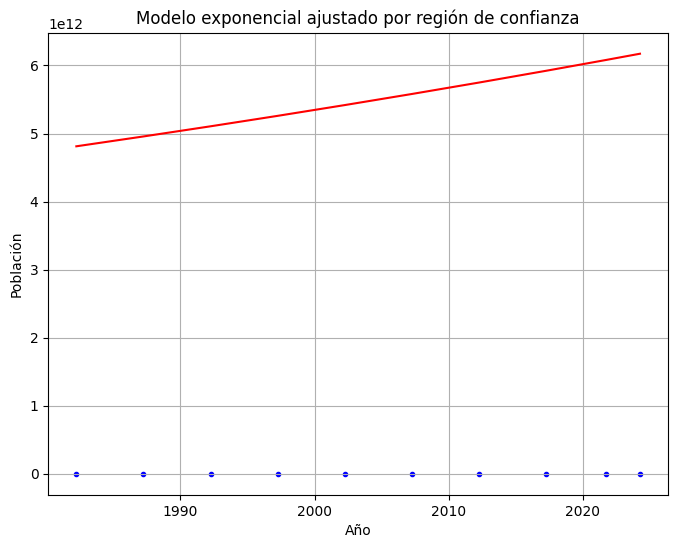

In [16]:
# Definir los datos experimentales
t = data_10.index.values
C = data_10['POBLACIÓN'].values

# Conversión de los datos a tipo float

t = t.astype(float)
# Convertir los valores a tipo float
C = np.array(C, dtype=float)

# Definir los valores iniciales de C0 y k, estos fueron tomados a partir de lo esperado y la relación entre los datos experimentales
k_inicial = np.log(C[0] / C[-1]) / (t[0] - t[-1])
x0 = np.array([C[-1], k_inicial])

# Resolver el problema utilizando el método de región de confianza
params_rc, itera = region_confianza(objective_function, x0, t, C)

C0_optimo, k_optimo = params_rc

# Mostrar los resultados
print('Parámetros encontrados por región de confianza:')
print('Población inicial estimada (C0):', C0_optimo)
print('Tasa de crecimiento estimada (k):', k_optimo)

#Impresión de la función obtenida por región de confianza
plt.figure(figsize=(8, 6))  # Definir el tamaño de la figura

# Gráfico de la función obtenida por región de confianza
plt.plot(data_10.index, C0_optimo * np.exp(k_optimo * t), color='red')  # Modelo exponencial ajustado
plt.scatter(data_10.index, data_10['POBLACIÓN'], color='blue', marker='.')  # Scatter plot
plt.title('Modelo exponencial ajustado por región de confianza')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y

plt.grid(True)  # Mostrar una cuadrícula en el gráfico

plt.show()  # Mostrar el gráfico

Hagamos la misma traslación realizada para todo el conjunto de datos en el conjunto de datos seleccionado, con el fin de ver como se comporta la población en función del tiempo y de la forma en que debería ajustarse el modelo exponencial a los datos experimentales.

Parámetros encontrados por región de confianza:
Población inicial estimada (C0): 37881973.00000149
Tasa de crecimiento estimada (k): 0.005928770316967909


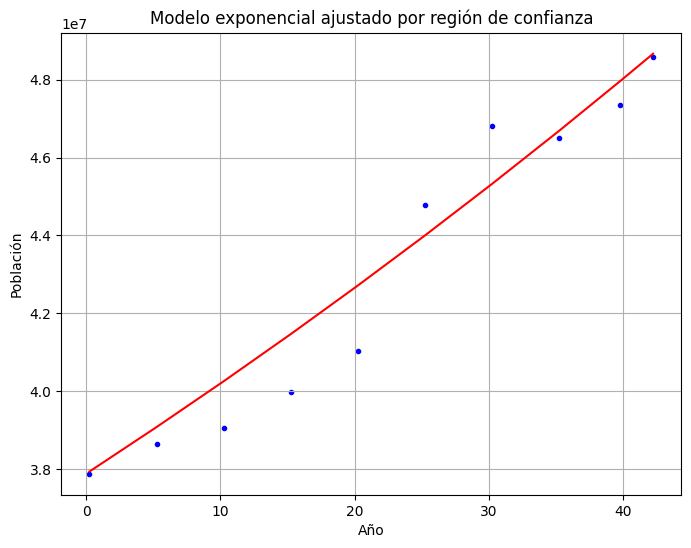

In [18]:
# Trasladar el tiempo para que el tiempo inicial sea el año 1971
data_10_traslacion = data_10.copy()
data_10_traslacion.index = data_10_traslacion.index - 1982

# Definir los datos experimentales
t = data_10_traslacion.index.values
C = data_10_traslacion['POBLACIÓN'].values
    
# Conversión de los datos a tipo float

t = t.astype(float)
# Convertir los valores a tipo float
C = np.array(C, dtype=float)

# Definir los valores iniciales de C0 y k, estos fueron tomados a partir de lo esperado y la relación entre los datos experimentales
k_inicial = np.log(C[0] / C[-1]) / (t[0] - t[-1])
x0 = np.array([C[-1], k_inicial])

# Resolver el problema utilizando el método de región de confianza
params_rc, itera = region_confianza(objective_function, x0, t, C)

C0_optimo, k_optimo = params_rc

# Mostrar los resultados
print('Parámetros encontrados por región de confianza:')
print('Población inicial estimada (C0):', C0_optimo)
print('Tasa de crecimiento estimada (k):', k_optimo)

#Impresión de la función obtenida por región de confianza
plt.figure(figsize=(8, 6))  # Definir el tamaño de la figura

# Gráfico de la función obtenida por región de confianza
plt.plot(data_10_traslacion.index, C0_optimo * np.exp(k_optimo * t), color='red')  # Modelo exponencial ajustado
plt.scatter(data_10_traslacion.index, data_10_traslacion['POBLACIÓN'], color='blue', marker='.')  # Scatter plot
plt.title('Modelo exponencial ajustado por región de confianza')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y

plt.grid(True)  # Mostrar una cuadrícula en el gráfico

plt.show()  # Mostrar el gráfico


Resulta que las gráficas de ambos métodos también resultan ser bastante parecidas, aunque lógicamente deben diferir en pequeños valores dados por la solución de los métodos. Así pues, los modelos exponenciales ajustados por ambos métodos son muy similares, lo cual sugiere que ambos métodos son efectivos para resolver el problema de ajuste de curvas a los datos experimentales. Por último, se procederá a realizar una comparación entre los tiempos de ejecución de ambos métodos.

In [276]:
import time

# Método de región de confianza
start_time = time.time()
params_rc = region_confianza(objective_function, x0, t, C)
end_time = time.time()
tiempo_rc = end_time - start_time

# Método de Gauss-Newton
start_time = time.time()
params_gn = gauss_newton(objective_function, x0, t, C)
end_time = time.time()
tiempo_gn = end_time - start_time

print('Tiempo de ejecución del método de región de confianza:', tiempo_rc)
print('Tiempo de ejecución del método de Gauss-Newton:', tiempo_gn)

Tiempo de ejecución del método de región de confianza: 5.068442106246948
Tiempo de ejecución del método de Gauss-Newton: 6.508516550064087


Como pudimos observar, el método de región de confianza tuvo un tiempo de ejecución de aproximadamente 5.1 segundos, mientras que el método de Gauss-Newton tuvo un tiempo de ejecución de aproximadamente 6.6 segundos. Por lo tanto, el método de región de confianza fue más rápido que el método de Gauss-Newton en este caso particular, aunque la diferencia en tiempo de ejecución no fue significativa. En general, ambos métodos son efectivos para resolver el problema de ajuste de curvas a los datos experimentales, aunque el método de región de confianza fue ligeramente más rápido en este caso particular, a pesar de que este tiempo de ejecución puede variar dependiendo de la complejidad del problema y de la implementación de los métodos.

En conclusión, en la realización de estos métodos se pudo evidenciar que ambos llegan a la solución del problema de mínimos cuadrados en un proceso bastante rápido, en donde ya es cuestión del usuario o del optimizador analizar los problemas y buscar cuál se adapta más, dadas las condiciones de los mismos y la complejidad de estos. Ahora bien, estos métodos difieren en su nivel de complejidad en términos de programación, pues el método de Gauss-Newton parece ser un método mucho más simple que el otro en cuestión, por lo que esto también puede ser determinante a la hora de escoger el método con el cual trabajar. Además de esto, como experiencia que deja el trabajo, podemos decir que es importante analizar muy bien el problema teóricamente, y verificar temas como los puntos iniciales, el manejo y la búsqueda de datos y las dimensiones de las matrices con las cuales se esta trabajando, esto puede llegar a ser bastante tedioso y puede llevar a errores muy simples, pero que se escapan al ojo humano, y una revisada del problema te puede ayudar a evitar estos problemas y a hacer un mejor manejo de los datos brindados. Finalmente, se puede decir que el trabajo fue bastante interesante y que se logró cumplir con los objetivos planteados en la tarea y pudimos ver como los métodos fueron de ayuda para resolver un problema de la vida cotidiana, como lo es el ajuste de curvas a datos experimentales, en nuestro caso, la población de un país en función del tiempo.